In [2]:
import keras
import tensorflow as tf


In [3]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split 
import tensorflow as tf
from tensorflow.keras import Model, backend
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
from keras.utils.vis_utils import plot_model


import cv2

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

palette_ro = ["#ee2f35", "#fa7211", "#fbd600", "#75c731", "#1fb86e", "#0488cf", "#7b44ab"]

In [4]:
!pip install pydicom

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [5]:
import pydicom

In [6]:
train=pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")

In [7]:
test=pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv")

In [8]:
sample=pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv")

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [10]:
train.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [11]:
test.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

# New Section
 **FINDING DUPLICATE VALUES IN TRAINING DATASET**


In [12]:
dup_rows=train[train.duplicated(subset=['Patient','Weeks'],keep=False)]

In [13]:
print("There are "+ str(len(dup_rows)) +" duplicate rows in the dataset")


There are 14 duplicate rows in the dataset


In [14]:
train.drop_duplicates(subset=['Patient','Weeks'],keep=False,inplace=True)

In [15]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [16]:
stats = []
for col in train.columns:
    stats.append((col,
                  train[col].nunique(),
                  train[col].value_counts().index[0],
                  train[col].value_counts().values[0],
                  train[col].isnull().sum() * 100 / train.shape[0],
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train[col].dtype))
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique values', 'Most frequent item', 'Freuquence of most frequent item', 'Percentage of missing values', 'Percentage of values in the biggest category', 'Type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique values,Most frequent item,Freuquence of most frequent item,Percentage of missing values,Percentage of values in the biggest category,Type
0,Patient,176,ID00099637202206203080121,10,0.0,0.651466,object
1,Weeks,112,12,44,0.0,2.866450,int64
2,FVC,1193,2708,4,0.0,0.260586,int64
3,Percent,1522,105.009715,2,0.0,0.130293,float64
4,Age,34,65,131,0.0,8.534202,int64
5,Sex,2,Male,1212,0.0,78.957655,object
6,SmokingStatus,3,Ex-smoker,1030,0.0,67.100977,object


In [17]:
data=train.groupby("Patient").first().reset_index(drop=True)

In [18]:
data.head()

,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,-4,2315,58.253649,79,Male,Ex-smoker
1,8,3660,85.282878,69,Male,Ex-smoker
2,0,3523,94.724672,60,Male,Ex-smoker
3,6,3326,85.987590,72,Male,Ex-smoker
4,33,3418,93.726006,65,Male,Never smoked


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/opt/conda/lib

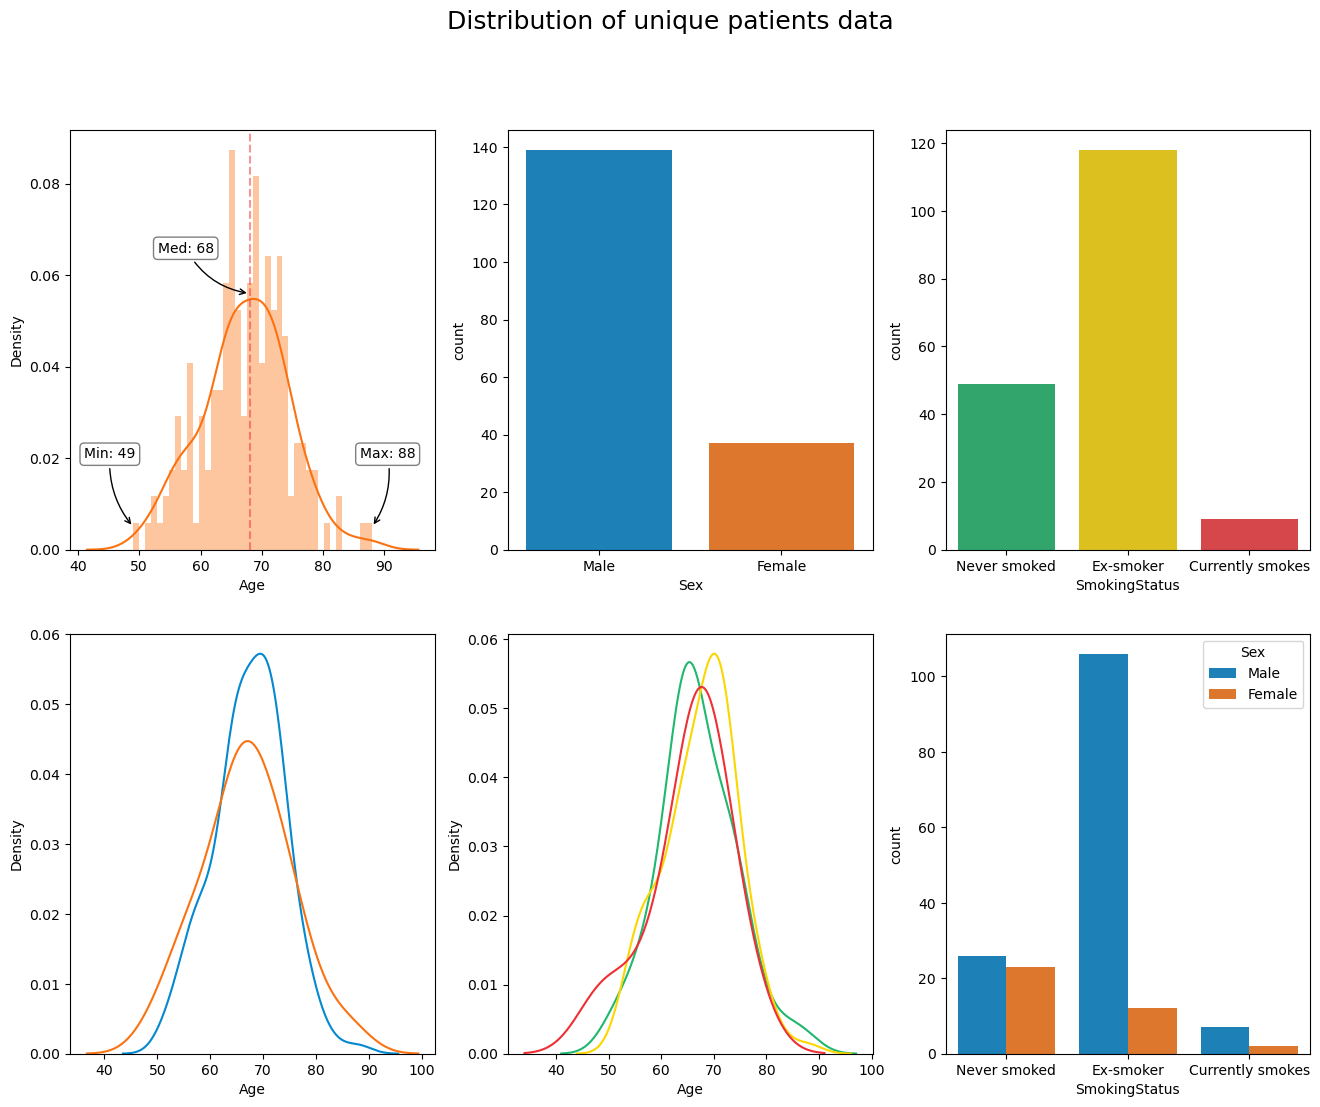

In [19]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 12))

sns.distplot(data["Age"], ax=ax1, bins=data["Age"].max()-data["Age"].min()+1, color=palette_ro[1])
ax1.annotate("Min: {:,}".format(data["Age"].min()), xy=(data["Age"].min(), 0.005), 
             xytext=(data["Age"].min()-8, 0.02),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=0.2"))
ax1.annotate("Max: {:,}".format(data["Age"].max()), xy=(data["Age"].max(), 0.005), 
             xytext=(data["Age"].max()-2, 0.02),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax1.axvline(x=data["Age"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax1.annotate("Med: {:.0f}".format(data["Age"].median()), xy=(data["Age"].median(), 0.056), 
             xytext=(data["Age"].median()-15, 0.065),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=0.25"))

sns.countplot(x="Sex", ax=ax2, data=data, palette=palette_ro[-2::-4])
sns.countplot(x="SmokingStatus", ax=ax3, data=data,
              order=["Never smoked", "Ex-smoker", "Currently smokes"], palette=palette_ro[-3::-2])

sns.distplot(data[data["Sex"]=="Male"].Age, label="Male", ax=ax4, hist=False, color=palette_ro[5])
sns.distplot(data[data["Sex"]=="Female"].Age, label="Female", ax=ax4, hist=False, color=palette_ro[1])

sns.distplot(data[data["SmokingStatus"]=="Never smoked"].Age, label="Never smoked", ax=ax5, hist=False, color=palette_ro[4])
sns.distplot(data[data["SmokingStatus"]=="Ex-smoker"].Age, label="Ex-smoker", ax=ax5, hist=False, color=palette_ro[2])
sns.distplot(data[data["SmokingStatus"]=="Currently smokes"].Age, label="Currently smokes", ax=ax5, hist=False, color=palette_ro[0])

sns.countplot(x="SmokingStatus", ax=ax6, data=data, hue="Sex",
              order=["Never smoked", "Ex-smoker", "Currently smokes"], palette=palette_ro[-2::-4])

fig.suptitle("Distribution of unique patients data", fontsize=18);

In [20]:
data["Sex"]=="Male"

0      True
1      True
2      True
3      True
4      True
       ... 
171    True
172    True
173    True
174    True
175    True
Name: Sex, Length: 176, dtype: bool

In [21]:
data[data["Sex"]=="Male"]['Age']

0      79
1      69
2      60
3      72
4      65
       ..
171    73
172    68
173    73
174    72
175    73
Name: Age, Length: 139, dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Weeks Distribution')

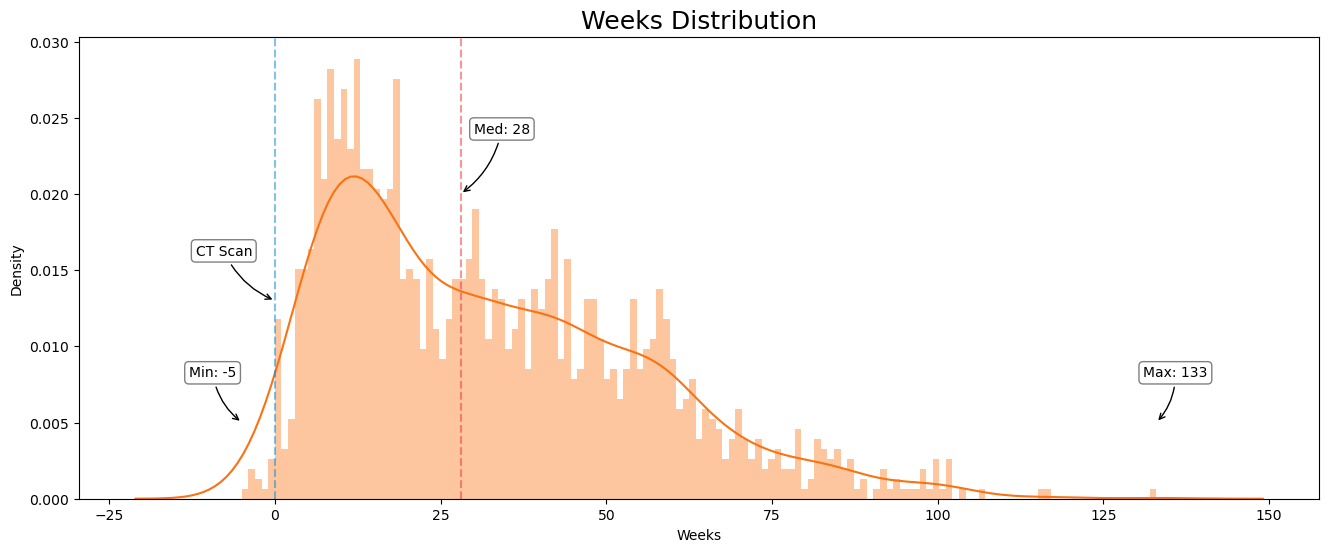

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.distplot(train["Weeks"], ax=ax, color=palette_ro[1], bins=train["Weeks"].max()-train["Weeks"].min()+1)
ax.annotate("Min: {:,}".format(train["Weeks"].min()), xy=(train["Weeks"].min(), 0.005), 
            xytext=(train["Weeks"].min()-8, 0.008),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))

ax.annotate("Max: {:,}".format(train["Weeks"].max()), xy=(train["Weeks"].max(), 0.005), 
            xytext=(train["Weeks"].max()-2, 0.008),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=-0.2"))

ax.axvline(x=0, color=palette_ro[5], linestyle="--", alpha=0.5)

ax.annotate("CT Scan", xy=(0, 0.013), 
            xytext=(-12, 0.016),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))

ax.axvline(x=train["Weeks"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)

ax.annotate("Med: {:.0f}".format(train["Weeks"].median()), xy=(train["Weeks"].median(), 0.020), 
            xytext=(train["Weeks"].median()+2, 0.024),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))

ax.set_title("Weeks Distribution", fontsize=18)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



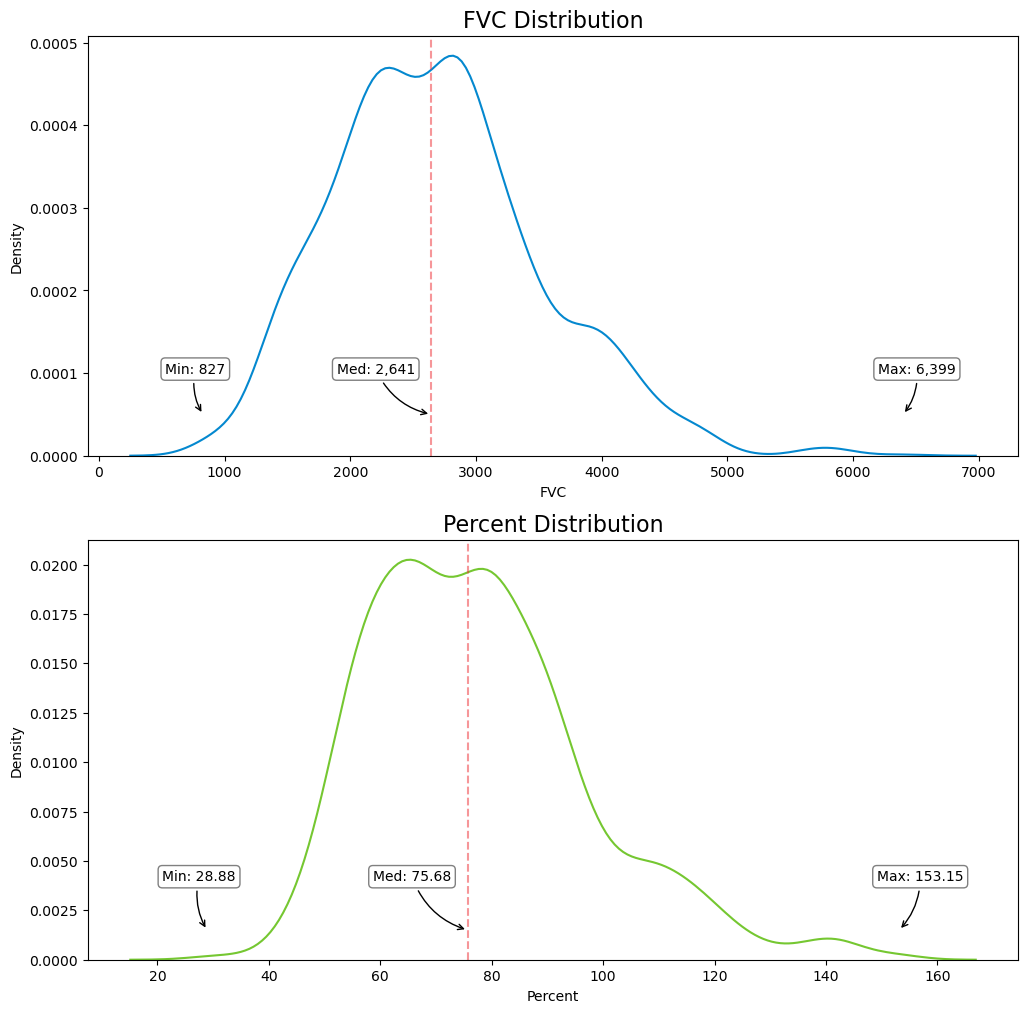

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.distplot(train["FVC"], ax=ax1, color=palette_ro[5], hist=False)
ax1.annotate("Min: {:,}".format(train["FVC"].min()), xy=(train["FVC"].min(), 0.00005), 
             xytext=(train["FVC"].min()-300, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax1.annotate("Max: {:,}".format(train["FVC"].max()), xy=(train["FVC"].max(), 0.00005), 
             xytext=(train["FVC"].max()-200, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax1.axvline(x=train["FVC"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax1.annotate("Med: {:,.0f}".format(train["FVC"].median()), xy=(train["FVC"].median(), 0.00005), 
             xytext=(train["FVC"].median()-750, 0.0001),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax1.set_title("FVC Distribution", fontsize=16);

sns.distplot(train["Percent"], ax=ax2, color=palette_ro[3], hist=False)
ax2.annotate("Min: {:.2f}".format(train["Percent"].min()), xy=(train["Percent"].min(), 0.0015), 
             xytext=(train["Percent"].min()-8, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3, rad=0.2"))
ax2.annotate("Max: {:.2f}".format(train["Percent"].max()), xy=(train["Percent"].max(), 0.0015), 
             xytext=(train["Percent"].max()-4, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3, rad=-0.2"))
ax2.axvline(x=train["Percent"].median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax2.annotate("Med: {:.2f}".format(train["Percent"].median()), xy=(train["Percent"].median(), 0.0015), 
             xytext=(train["Percent"].median()-17, 0.0040),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax2.set_title("Percent Distribution", fontsize=16);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # R

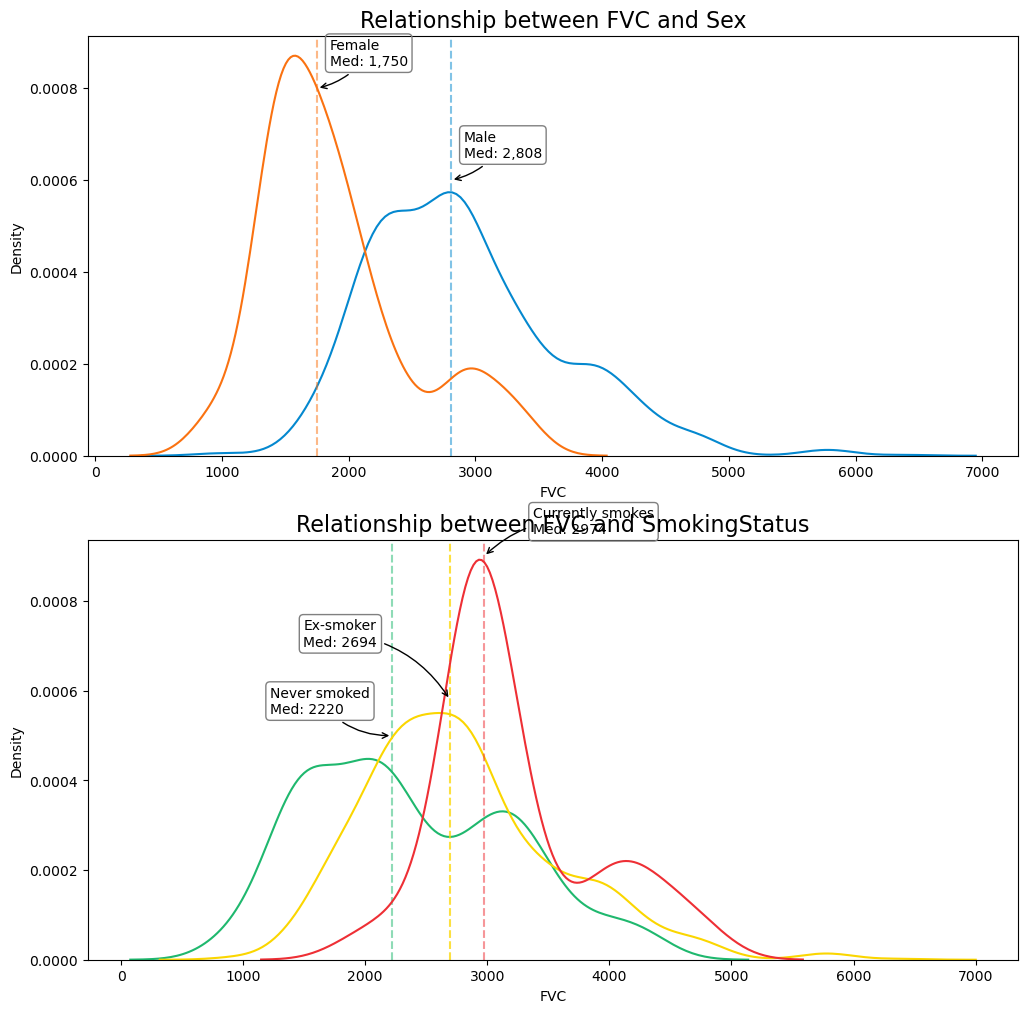

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.distplot(train[train["Sex"]=="Male"].FVC, label="Male", ax=ax1, hist=False, color=palette_ro[5])
ax1.axvline(x=train[train["Sex"]=="Male"].FVC.median(), color=palette_ro[5], linestyle="--", alpha=0.5)
ax1.annotate("Male\nMed: {:,.0f}".format(train[train["Sex"]=="Male"].FVC.median()), xy=(train[train["Sex"]=="Male"].FVC.median(), 0.0006), 
             xytext=(train[train["Sex"]=="Male"].FVC.median()+100, 0.00065),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))
sns.distplot(train[train["Sex"]=="Female"].FVC, label="Female", ax=ax1, hist=False, color=palette_ro[1])
ax1.axvline(x=train[train["Sex"]=="Female"].FVC.median(), color=palette_ro[1], linestyle="--", alpha=0.5)
ax1.annotate("Female\nMed: {:,.0f}".format(train[train["Sex"]=="Female"].FVC.median()), xy=(train[train["Sex"]=="Female"].FVC.median(), 0.0008), 
             xytext=(train[train["Sex"]=="Female"].FVC.median()+100, 0.00085),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))

sns.distplot(train[train["SmokingStatus"]=="Never smoked"].FVC, label="Never smoked", ax=ax2, hist=False, color=palette_ro[4])
ax2.axvline(x=train[train["SmokingStatus"]=="Never smoked"].FVC.median(), color=palette_ro[4], linestyle="--", alpha=0.5)
ax2.annotate("Never smoked\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Never smoked"].FVC.median()), xy=(train[train["SmokingStatus"]=="Never smoked"].FVC.median(), 0.0005), 
             xytext=(train[train["SmokingStatus"]=="Never smoked"].FVC.median()-1000, 0.00055),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))
sns.distplot(train[train["SmokingStatus"]=="Ex-smoker"].FVC, label="Ex-smoker", ax=ax2, hist=False, color=palette_ro[2])
ax2.axvline(x=train[train["SmokingStatus"]=="Ex-smoker"].FVC.median(), color=palette_ro[2], linestyle="--", alpha=0.75)
ax2.annotate("Ex-smoker\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median()), xy=(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median(), 0.00058), 
             xytext=(train[train["SmokingStatus"]=="Ex-smoker"].FVC.median()-1200, 0.0007),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.25"))
sns.distplot(train[train["SmokingStatus"]=="Currently smokes"].FVC, label="Currently smokes", ax=ax2, hist=False, color=palette_ro[0])
ax2.axvline(x=train[train["SmokingStatus"]=="Currently smokes"].FVC.median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax2.annotate("Currently smokes\nMed: {:.0f}".format(train[train["SmokingStatus"]=="Currently smokes"].FVC.median()), xy=(train[train["SmokingStatus"]=="Currently smokes"].FVC.median(), 0.0009), 
             xytext=(train[train["SmokingStatus"]=="Currently smokes"].FVC.median()+400, 0.00095),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax1.set_title("Relationship between FVC and Sex", fontsize=16)
ax2.set_title("Relationship between FVC and SmokingStatus", fontsize=16);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: U

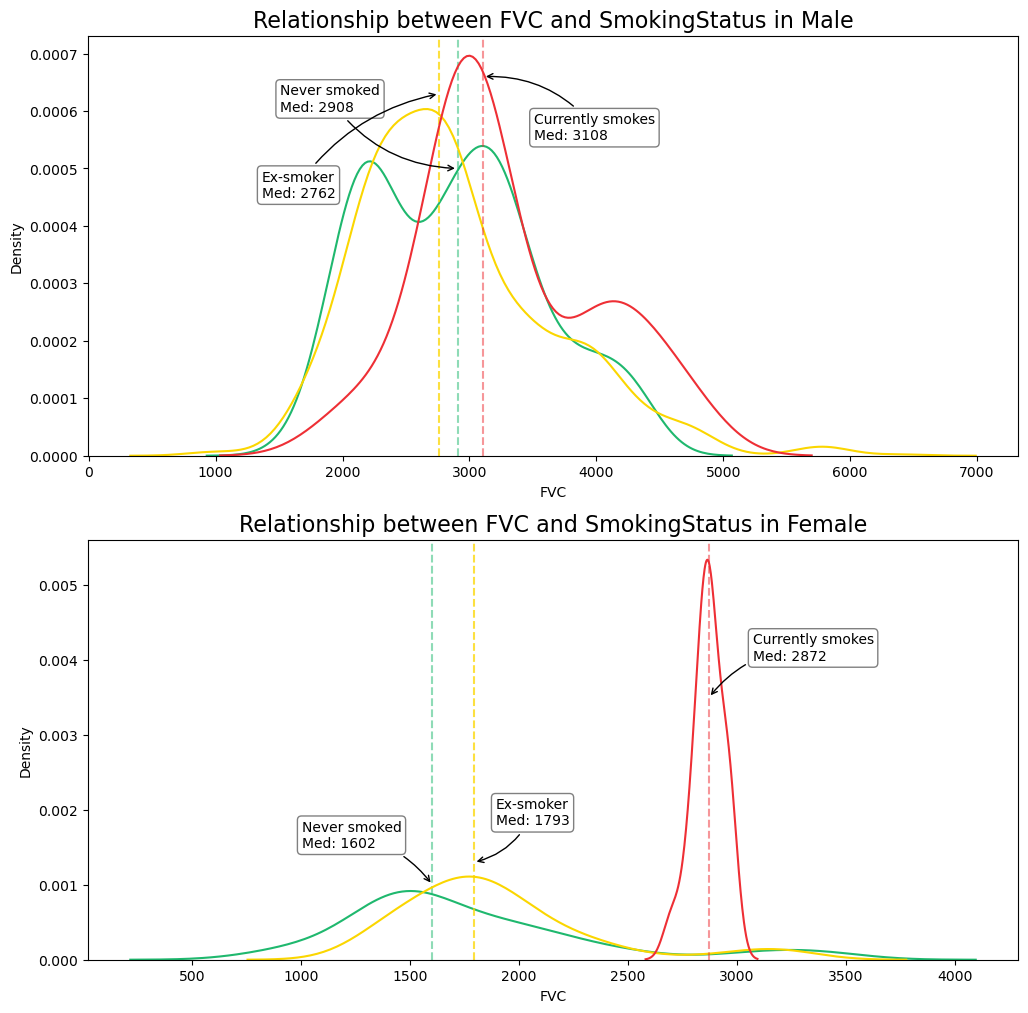

In [25]:
train_m = train[train["Sex"]=="Male"].reset_index(drop=True)
train_f = train[train["Sex"]=="Female"].reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.distplot(train_m[train_m["SmokingStatus"]=="Never smoked"].FVC, label="Never smoked", ax=ax1, hist=False, color=palette_ro[4])
ax1.axvline(x=train_m[train_m["SmokingStatus"]=="Never smoked"].FVC.median(), color=palette_ro[4], linestyle="--", alpha=0.5)
ax1.annotate("Never smoked\nMed: {:.0f}".format(train_m[train_m["SmokingStatus"]=="Never smoked"].FVC.median()), xy=(train_m[train_m["SmokingStatus"]=="Never smoked"].FVC.median(), 0.0005), 
             xytext=(train_m[train_m["SmokingStatus"]=="Never smoked"].FVC.median()-1400, 0.0006),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))
sns.distplot(train_m[train_m["SmokingStatus"]=="Ex-smoker"].FVC, label="Ex-smoker", ax=ax1, hist=False, color=palette_ro[2])
ax1.axvline(x=train_m[train_m["SmokingStatus"]=="Ex-smoker"].FVC.median(), color=palette_ro[2], linestyle="--", alpha=0.75)
ax1.annotate("Ex-smoker\nMed: {:.0f}".format(train_m[train_m["SmokingStatus"]=="Ex-smoker"].FVC.median()), xy=(train_m[train_m["SmokingStatus"]=="Ex-smoker"].FVC.median(), 0.00063), 
             xytext=(train_m[train_m["SmokingStatus"]=="Ex-smoker"].FVC.median()-1400, 0.00045),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))
sns.distplot(train_m[train_m["SmokingStatus"]=="Currently smokes"].FVC, label="Currently smokes", ax=ax1, hist=False, color=palette_ro[0])
ax1.axvline(x=train_m[train_m["SmokingStatus"]=="Currently smokes"].FVC.median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax1.annotate("Currently smokes\nMed: {:.0f}".format(train_m[train_m["SmokingStatus"]=="Currently smokes"].FVC.median()), xy=(train_m[train_m["SmokingStatus"]=="Currently smokes"].FVC.median(), 0.00066), 
             xytext=(train_m[train_m["SmokingStatus"]=="Currently smokes"].FVC.median()+400, 0.00055),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

sns.distplot(train_f[train_f["SmokingStatus"]=="Never smoked"].FVC, label="Never smoked", ax=ax2, hist=False, color=palette_ro[4])
ax2.axvline(x=train_f[train_f["SmokingStatus"]=="Never smoked"].FVC.median(), color=palette_ro[4], linestyle="--", alpha=0.5)
ax2.annotate("Never smoked\nMed: {:.0f}".format(train_f[train_f["SmokingStatus"]=="Never smoked"].FVC.median()), xy=(train_f[train_f["SmokingStatus"]=="Never smoked"].FVC.median(), 0.001), 
             xytext=(train_f[train_f["SmokingStatus"]=="Never smoked"].FVC.median()-600, 0.0015),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.2"))
sns.distplot(train_f[train_f["SmokingStatus"]=="Ex-smoker"].FVC, label="Ex-smoker", ax=ax2, hist=False, color=palette_ro[2])
ax2.axvline(x=train_f[train_f["SmokingStatus"]=="Ex-smoker"].FVC.median(), color=palette_ro[2], linestyle="--", alpha=0.75)
ax2.annotate("Ex-smoker\nMed: {:.0f}".format(train_f[train_f["SmokingStatus"]=="Ex-smoker"].FVC.median()), xy=(train_f[train_f["SmokingStatus"]=="Ex-smoker"].FVC.median(), 0.0013), 
             xytext=(train_f[train_f["SmokingStatus"]=="Ex-smoker"].FVC.median()+100, 0.0018),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=-0.25"))
sns.distplot(train_f[train_f["SmokingStatus"]=="Currently smokes"].FVC, label="Currently smokes", ax=ax2, hist=False, color=palette_ro[0])
ax2.axvline(x=train_f[train_f["SmokingStatus"]=="Currently smokes"].FVC.median(), color=palette_ro[0], linestyle="--", alpha=0.5)
ax2.annotate("Currently smokes\nMed: {:.0f}".format(train_f[train_f["SmokingStatus"]=="Currently smokes"].FVC.median()), xy=(train_f[train_f["SmokingStatus"]=="Currently smokes"].FVC.median(), 0.0035), 
             xytext=(train_f[train_f["SmokingStatus"]=="Currently smokes"].FVC.median()+200, 0.004),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
             arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3, rad=0.25"))

ax1.set_title("Relationship between FVC and SmokingStatus in Male", fontsize=16)
ax2.set_title("Relationship between FVC and SmokingStatus in Female", fontsize=16);


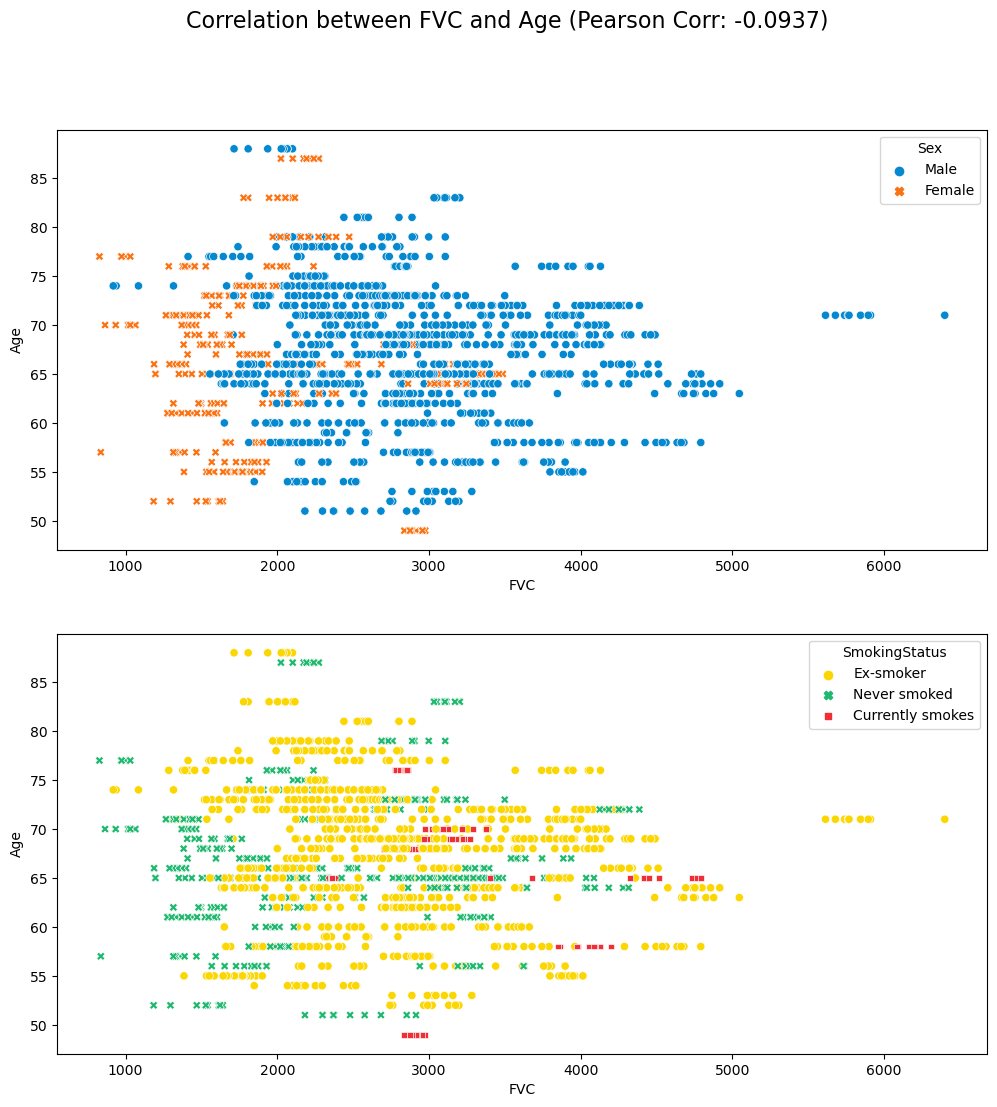

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(x=train["FVC"], y=train["Age"], ax=ax1,
                palette=[palette_ro[5], palette_ro[1]], hue=train["Sex"],style=train["Sex"])
sns.scatterplot(x=train["FVC"], y=train["Age"], ax=ax2,
                palette=[palette_ro[2], palette_ro[4], palette_ro[0]], hue=train["SmokingStatus"], style=train["SmokingStatus"])

fig.suptitle("Correlation between FVC and Age (Pearson Corr: {:.4f})".format(train["FVC"].corr(train["Age"])), fontsize=16);

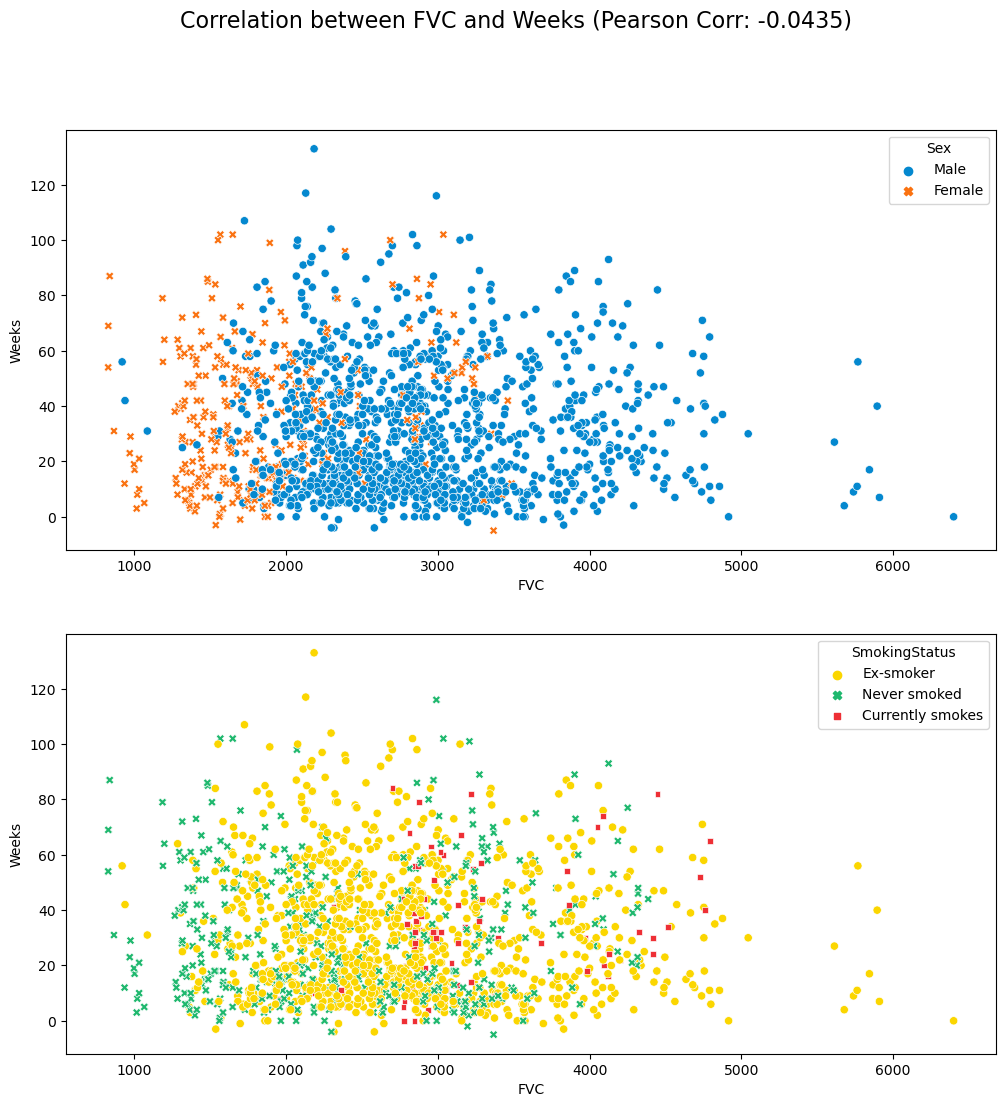

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(x=train["FVC"], y=train["Weeks"], ax=ax1,
                palette=[palette_ro[5], palette_ro[1]], hue=train["Sex"], style=train["Sex"])
sns.scatterplot(x=train["FVC"], y=train["Weeks"], ax=ax2,
                palette=[palette_ro[2], palette_ro[4], palette_ro[0]], hue=train["SmokingStatus"], style=train["SmokingStatus"])

fig.suptitle("Correlation between FVC and Weeks (Pearson Corr: {:.4f})".format(train["FVC"].corr(train["Weeks"])), fontsize=16);

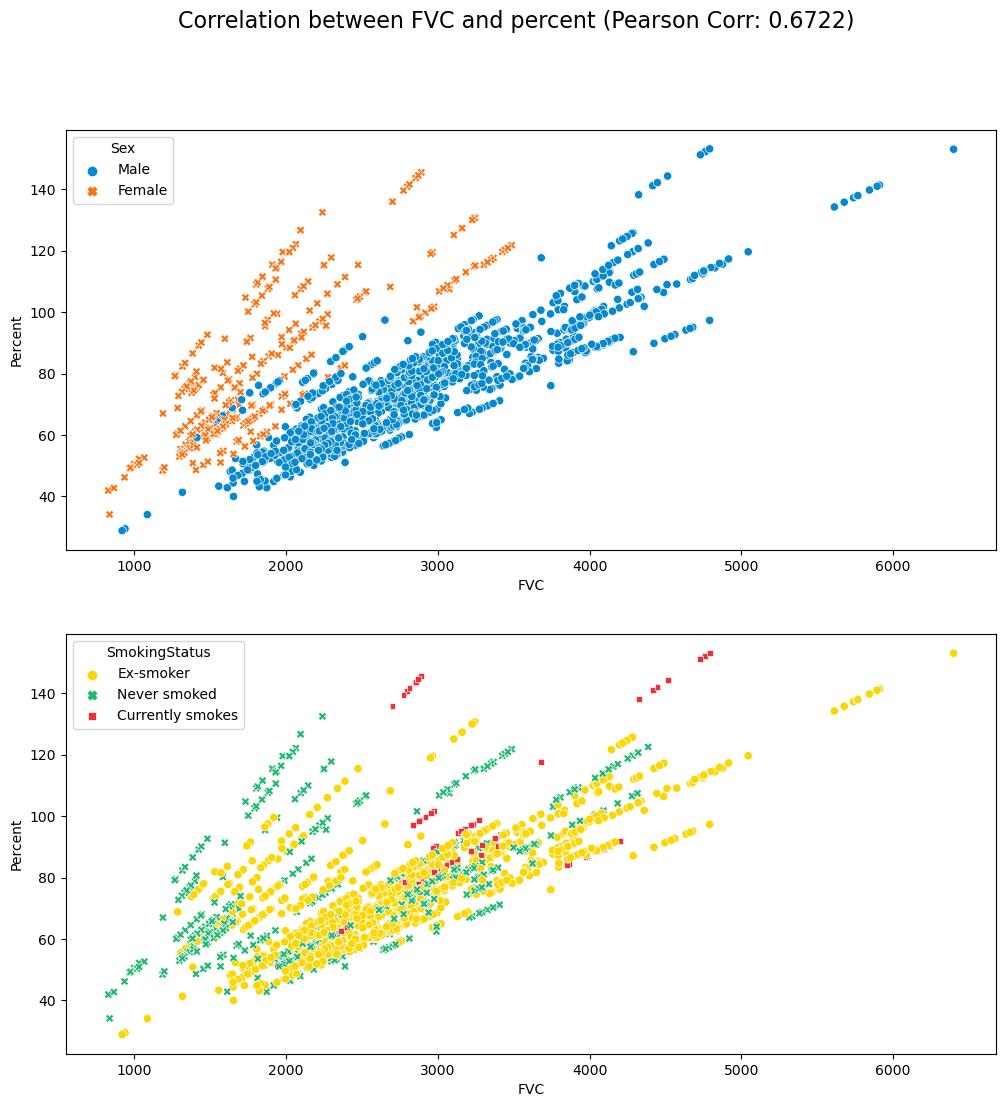

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(x=train["FVC"], y=train["Percent"], ax=ax1,
                palette=[palette_ro[5], palette_ro[1]], hue=train["Sex"], style=train["Sex"])
sns.scatterplot(x=train["FVC"], y=train["Percent"], ax=ax2,
                palette=[palette_ro[2], palette_ro[4], palette_ro[0]], hue=train["SmokingStatus"], style=train["SmokingStatus"])

fig.suptitle("Correlation between FVC and percent (Pearson Corr: {:.4f})".format(train["FVC"].corr(train["Percent"])), fontsize=16);

**THERE IS A POSITIVE CORRELATION BETWEEN PERCENT AND FVC WHICH CAN BE SEEN FROM THE ABOVE SCATTERPLOT**

**LINEAR DECAY APPROACH**

In [29]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [30]:
train.Age.values[0]

79

In [31]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30]
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [32]:
train.Patient.unique

<bound method Series.unique of 0       ID00007637202177411956430
1       ID00007637202177411956430
2       ID00007637202177411956430
3       ID00007637202177411956430
4       ID00007637202177411956430
                  ...            
1544    ID00426637202313170790466
1545    ID00426637202313170790466
1546    ID00426637202313170790466
1547    ID00426637202313170790466
1548    ID00426637202313170790466
Name: Patient, Length: 1535, dtype: object>

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


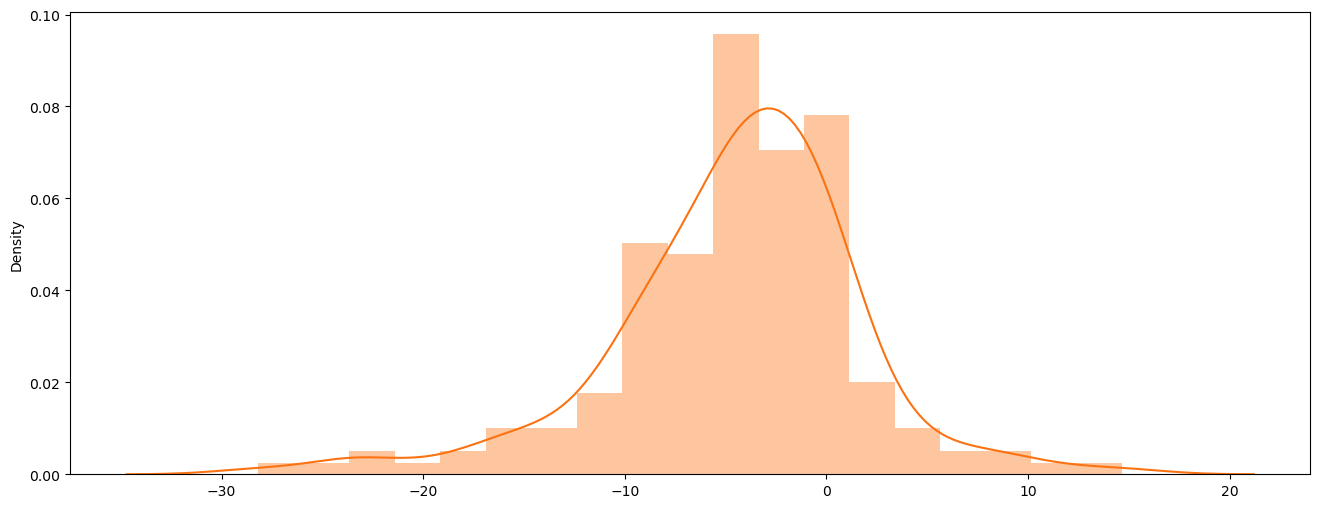

In [33]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.distplot(list(A.values()), ax=ax, color=palette_ro[1]);

In [34]:
def get_img(path, new_shape=(528, 528)):
    d = pydicom.dcmread(path)
    scan = d.pixel_array / 2**11
    
    left = int((scan.shape[0]-512)/2)
    right = int((scan.shape[0]+512)/2)
    top = int((scan.shape[1]-512)/2)
    bottom = int((scan.shape[1]+512)/2)
    
    img = scan[top:bottom, left:right]
    cropped_resized_scan = cv2.resize(img, new_shape, interpolation=cv2.INTER_LANCZOS4)
    return cropped_resized_scan

In [35]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [36]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [37]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB4 ,EfficientNetB5 ,EfficientNetB1,EfficientNetB2,EfficientNetB6,EfficientNetB7

In [38]:
def get_efficientnet(model, shape):
    models_dict = {
        'b0': EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(528, 528, 1), model_class=None):    # changed from 512
    inp = L.Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = L.GlobalAveragePooling2D()(x)
    inp2 = L.Input(shape=(4,))
    x2 = L.GaussianNoise(0.2)(inp2)
    x = L.Concatenate()([x, x2]) 
    x = L.Dropout(0.32)(x)    # changed from 0.4
    x = L.Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('/kaggle/input/osic-model-weights') if model_class in w][0]
    model.load_weights('/kaggle/input/osic-model-weights/' + weights,by_name=True,skip_mismatch=True)
    return model

model_classes = ["b6"] #['b0','b1','b2','b3',b4','b5','b6','b7']    # changed from b5
models = [build_model(model_class=m, shape=(528, 528, 1)) for m in model_classes]    # changed from 512
print('Number of models: ' + str(len(models)))


Number of models: 1


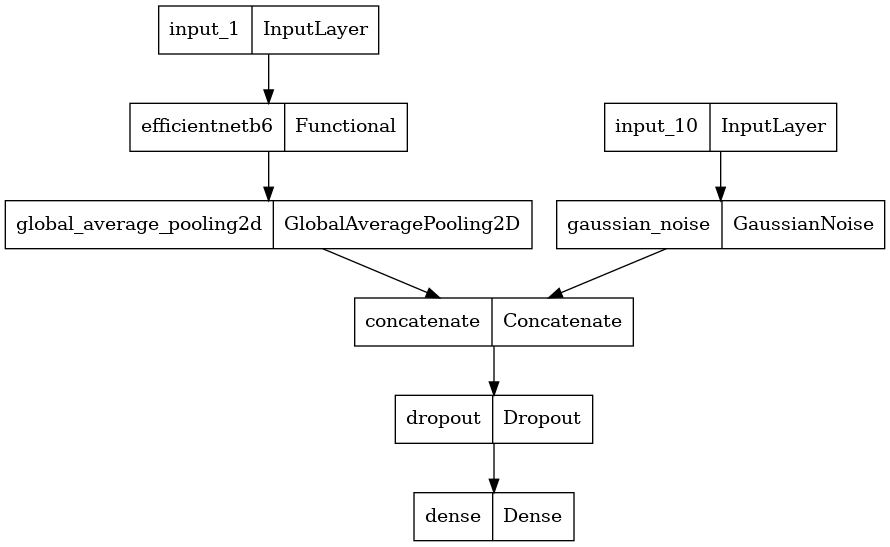

In [39]:
plot_model(models[0])

In [40]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip * sq2)
    return np.mean(metric)

In [41]:
tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size=0.8)

subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'/kaggle/input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'/kaggle/input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test, W, FVC = {}, {}, {}, {}, {} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'/kaggle/input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'/kaggle/input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, "FVC"] = fvc
        sub.loc[sub.Patient_Week == k, "Confidence"] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

  0%|          | 0/9 [00:00<?, ?it/s]

2/2 [==============================] - 1s 637ms/step
7.145350041137228
2/2 [==============================] - 1s 636ms/step
7.145350048310411
2/2 [==============================] - 1s 636ms/step
7.145350052434974
2/2 [==============================] - 1s 636ms/step
7.145350053959165
2/2 [==============================] - 1s 637ms/step
7.145350058117401
2/2 [==============================] - 1s 637ms/step
7.145350060363999
2/2 [==============================] - 1s 635ms/step
7.145350064074246
2/2 [==============================] - 1s 637ms/step
7.145350065712934
2/2 [==============================] - 1s 628ms/step
7.145350069931341
9/9 [==============================] - 7s 825ms/step


In [68]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [69]:
sub[["Patient_Week", "FVC", "Confidence"]].to_csv("submission_img.csv", index=False)

In [70]:
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3027.116612,77.303467
1,ID00421637202311550012437_-12,2749.536178,92.581469
2,ID00422637202311677017371_-12,1937.116613,83.789106
3,ID00423637202312137826377_-12,3305.435851,90.694754
4,ID00426637202313170790466_-12,2928.287254,75.112222
...,...,...,...
725,ID00419637202311204720264_133,2969.788350,120.398505
726,ID00421637202311550012437_133,2692.953001,128.092290
727,ID00422637202311677017371_133,1879.788342,126.884151
728,ID00423637202312137826377_133,3248.256597,125.002306


**The linear decay prediction have been made(based on EFFICIENT NET)**

**Quantile Regression**

In [71]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [101]:
subm=pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv")
subm.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [103]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n
1535,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.332421,0.615385,0.372400,0.179012
1536,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.427848,0.487179,0.320208,0.179012
1537,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.384612,0.615385,0.169948,0.179012
1538,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.405425,0.589744,0.423291,0.179012
1539,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,val,NaN,NaN,...,0.0,1,0,0,1,0,0.345604,0.615385,0.354755,0.179012


In [102]:
subm['Patient'] = subm['Patient_Week'].apply(lambda x:x.split('_')[0])
subm['Weeks'] = subm['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
subm =  subm[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
subm = subm.merge(test.drop('Weeks', axis=1), on="Patient")
subm.head()

,Patient,Weeks,Confidence_x,Patient_Week_x,FVC,Percent,Age,Sex,SmokingStatus,WHERE,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker,val,...,0.0,1,0,1,0,0,0.332421,0.615385,0.3724,0.179012
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker,val,...,0.0,1,0,1,0,0,0.332421,0.615385,0.3724,0.179012
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker,val,...,0.0,1,0,1,0,0,0.332421,0.615385,0.3724,0.179012
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker,val,...,0.0,1,0,1,0,0,0.332421,0.615385,0.3724,0.179012
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker,val,...,0.0,1,0,1,0,0,0.332421,0.615385,0.3724,0.179012


In [109]:
train['WHERE'] = 'train'
test['WHERE'] = 'val'
sub['WHERE'] = 'test'
data_1 = train.append([test, sub])

print(train.shape, test.shape, subm.shape, data.shape)
print(train.Patient.nunique(), test.Patient.nunique(), subm.Patient.nunique(), data.Patient.nunique())

data.head(10)

(1535, 22) (5, 22) (730, 24) (2270, 26)
176 5 5 176


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.193059,0.769231,0.241456,0.308642,NaN,NaN,NaN,NaN
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.172607,0.769231,0.241456,0.382716,NaN,NaN,NaN,NaN
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.185567,0.769231,0.241456,0.456790,NaN,NaN,NaN,NaN
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184150,0.769231,0.241456,0.555556,NaN,NaN,NaN,NaN
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.453901,0.512821,0.491270,0.179012,NaN,NaN,NaN,NaN


In [110]:
data_1['min_week'] = data_1['Weeks']
data_1.loc[data_1.WHERE=='test', 'min_week'] = np.nan
data_1['min_week'] = data_1.groupby('Patient')['min_week'].transform('min')

data_1.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.193059,0.769231,0.241456,0.308642,NaN,NaN,NaN,NaN
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.172607,0.769231,0.241456,0.382716,NaN,NaN,NaN,NaN
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.185567,0.769231,0.241456,0.456790,NaN,NaN,NaN,NaN
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184150,0.769231,0.241456,0.555556,NaN,NaN,NaN,NaN
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.453901,0.512821,0.491270,0.179012,NaN,NaN,NaN,NaN


In [112]:
base = data_1.loc[data_1.Weeks == data_1.min_week]
base = base[['Patient', 'FVC']].copy()
base.columns = ['Patient', 'base_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

base.head()

,Patient,base_FVC
0,ID00007637202177411956430,2315
9,ID00009637202177434476278,3660
18,ID00010637202177584971671,3523
27,ID00011637202177653955184,3326
36,ID00012637202177665765362,3418


In [113]:
data_1 = data_1.merge(base, on='Patient', how='left')
data_1['base_week'] = data_1['Weeks'] - data_1['min_week']
del base

data_1.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y,base_FVC_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN,2315
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN,2315
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN,2315
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN,2315
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN,2315
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.193059,0.769231,0.241456,0.308642,NaN,NaN,NaN,NaN,2315
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.172607,0.769231,0.241456,0.382716,NaN,NaN,NaN,NaN,2315
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.185567,0.769231,0.241456,0.456790,NaN,NaN,NaN,NaN,2315
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.184150,0.769231,0.241456,0.555556,NaN,NaN,NaN,NaN,2315
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,...,0,0.453901,0.512821,0.491270,0.179012,NaN,NaN,NaN,NaN,3660


In [114]:
categorical_features = ['Sex', 'SmokingStatus']
features_nn = []
for col in categorical_features:
    for mod in data_1[col].unique():
        features_nn.append(mod)
        data_1[mod] = (data_1[col] == mod).astype(int)

data_1.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y,base_FVC_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN,2315
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN,2315
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN,2315
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN,2315
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN,2315
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.193059,0.769231,0.241456,0.308642,NaN,NaN,NaN,NaN,2315
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.172607,0.769231,0.241456,0.382716,NaN,NaN,NaN,NaN,2315
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.185567,0.769231,0.241456,0.456790,NaN,NaN,NaN,NaN,2315
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,train,NaN,NaN,...,0,0.184150,0.769231,0.241456,0.555556,NaN,NaN,NaN,NaN,2315
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,...,0,0.453901,0.512821,0.491270,0.179012,NaN,NaN,NaN,NaN,3660


In [115]:
data_1['Percent_n'] = (data_1['Percent'] - data_1['Percent'].min() ) / ( data_1['Percent'].max() - data_1['Percent'].min() )
data_1['Age_n'] = (data_1['Age'] - data_1['Age'].min() ) / ( data_1['Age'].max() - data_1['Age'].min() )
data_1['base_FVC_n'] = (data_1['base_FVC_y'] - data_1['base_FVC_y'].min() ) / ( data_1['base_FVC_y'].max() - data_1['base_FVC_y'].min() )
data_1['base_week_n'] = (data_1['base_week'] - data_1['base_week'].min() ) / ( data_1['base_week'].max() - data_1['base_week'].min() )
features_nn += ['Age_n', 'Percent_n', 'base_week_n', 'base_FVC_n']

print(features_nn)
data.head(10)

['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'Age_n', 'Percent_n', 'base_week_n', 'base_FVC_n']


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.193059,0.769231,0.241456,0.308642,NaN,NaN,NaN,NaN
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.172607,0.769231,0.241456,0.382716,NaN,NaN,NaN,NaN
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.185567,0.769231,0.241456,0.456790,NaN,NaN,NaN,NaN
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184150,0.769231,0.241456,0.555556,NaN,NaN,NaN,NaN
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.453901,0.512821,0.491270,0.179012,NaN,NaN,NaN,NaN


In [117]:
train = data.loc[data.WHERE=='train']
test = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data



In [118]:
train.shape, test.shape, sub.shape

((1535, 26), (5, 26), (730, 26))

In [119]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.236393,0.769231,0.241456,0.179012,NaN,NaN,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.215941,0.769231,0.241456,0.234568,NaN,NaN,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.184960,0.769231,0.241456,0.246914,NaN,NaN,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.201767,0.769231,0.241456,0.259259,NaN,NaN,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,0,0,0.186580,0.769231,0.241456,0.271605,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,train,NaN,NaN,...,1,0,0.303514,0.615385,0.354755,0.259259,NaN,NaN,NaN,NaN
1531,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,train,NaN,NaN,...,1,0,0.356076,0.615385,0.354755,0.296296,NaN,NaN,NaN,NaN
1532,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,train,NaN,NaN,...,1,0,0.342244,0.615385,0.354755,0.370370,NaN,NaN,NaN,NaN
1533,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,train,NaN,NaN,...,1,0,0.355484,0.615385,0.354755,0.444444,NaN,NaN,NaN,NaN


**BUILD THE MODEL**

In [135]:
C1, C2 = tf.constant(70, dtype="float32"), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]

    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip * sq2)
    return backend.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    y_true = tf.cast(y_true, tf.float32)
    
    qs = [0.2, 0.5, 0.8]
    q = tf.convert_to_tensor(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return backend.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [136]:
def make_model():
    inp = L.Input(len(features_nn), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(inp)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(inp, preds, name="NeuralNet")
    model.compile(loss=mloss(0.64),    # changed from 0.8
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, decay=0.01),
                  metrics=[score])
    return model

model = make_model()
model.summary()

Model: "NeuralNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Patient (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 d1 (Dense)                     (None, 100)          1000        ['Patient[0][0]']                
                                                                                                  
 d2 (Dense)                     (None, 100)          10100       ['d1[0][0]']                     
                                                                                                  
 p1 (Dense)                     (None, 3)            303         ['d2[0][0]']                     
                                                                                          

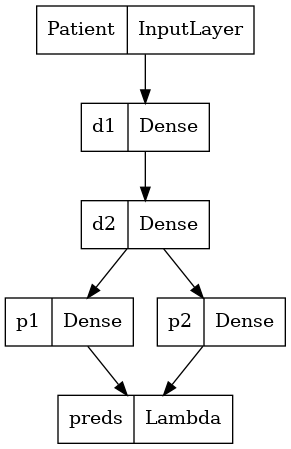

In [137]:
plot_model(model)

**Cross-Validation**

In [141]:
X_train = train[features_nn].values
X_test = sub[features_nn].values

y_train = train['FVC'].values.astype(np.float32)

oof_train = np.zeros((X_train.shape[0], 3))
y_preds = np.zeros((X_test.shape[0], 3))

In [142]:
BATCH_SIZE = 128
EPOCHS = 804    # changed from 800
NFOLD = 5

kf = KFold(n_splits=NFOLD)

In [143]:
%%time
for fold_id, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    print(f"FOLD {fold_id+1}")
    model = make_model()
    model.fit(X_train[tr_idx], y_train[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
              validation_data=(X_train[va_idx], y_train[va_idx]), verbose=0)
    print("train", model.evaluate(X_train[tr_idx], y_train[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", model.evaluate(X_train[va_idx], y_train[va_idx], verbose=0, batch_size=BATCH_SIZE))
    oof_train[va_idx] = model.predict(X_train[va_idx], batch_size=BATCH_SIZE, verbose=0)
    y_preds += model.predict(X_test, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [31.859514236450195, 6.464955806732178]
val [40.216312408447266, 6.777557849884033]
FOLD 2
train [32.67469787597656, 6.48021936416626]
val [40.6028938293457, 6.7277140617370605]
FOLD 3
train [31.42690086364746, 6.436765193939209]
val [46.397647857666016, 6.752151966094971]
FOLD 4
train [32.6981315612793, 6.469538688659668]
val [33.02670669555664, 6.468969821929932]
FOLD 5
train [32.863616943359375, 6.478117942810059]
val [40.33095932006836, 6.727120876312256]
CPU times: user 3min 49s, sys: 14.3 s, total: 4min 3s
Wall time: 4min 54s


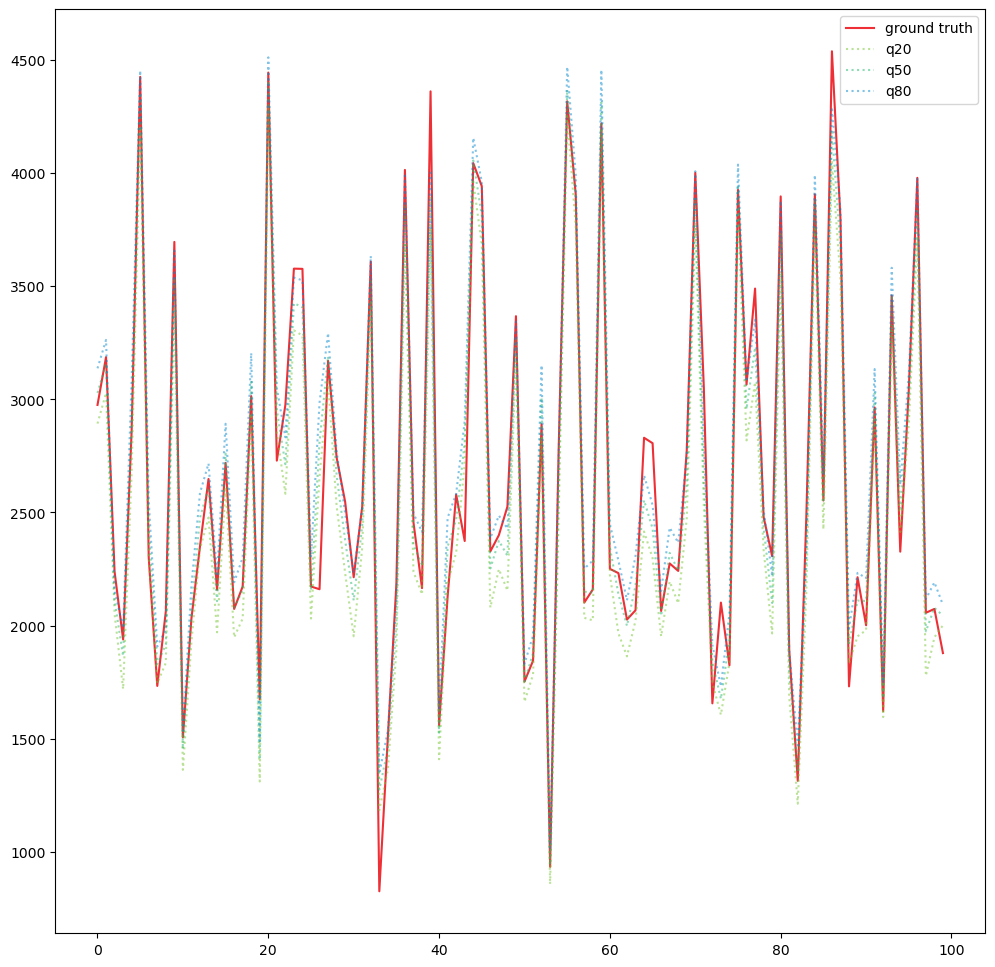

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))

idxs = np.random.randint(0, y_train.shape[0], 100)
ax.plot(y_train[idxs], label="ground truth", color=palette_ro[0])
ax.plot(oof_train[idxs, 0], label="q20", color=palette_ro[3], ls=':', alpha=0.5)
ax.plot(oof_train[idxs, 1], label="q50", color=palette_ro[4], ls=':', alpha=0.5)
ax.plot(oof_train[idxs, 2], label="q80", color=palette_ro[5], ls=':', alpha=0.5)
ax.legend(loc="best");

In [149]:
sigma_opt = mean_absolute_error(y_train, oof_train[:, 1])
sigma_unc = oof_train[:, 2] - oof_train[:, 0]
sigma_mean = np.mean(sigma_unc)
print(sigma_opt, sigma_mean)

141.70918998594004 227.7119465483128


In [150]:
print(sigma_unc.min(), sigma_unc.mean(), sigma_unc.max(), (sigma_unc>=0).mean())

11.010498046875 227.7119465483128 407.429931640625 1.0


In [151]:
print(np.mean(y_train / oof_train[:, 1]))

1.001591056811357


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


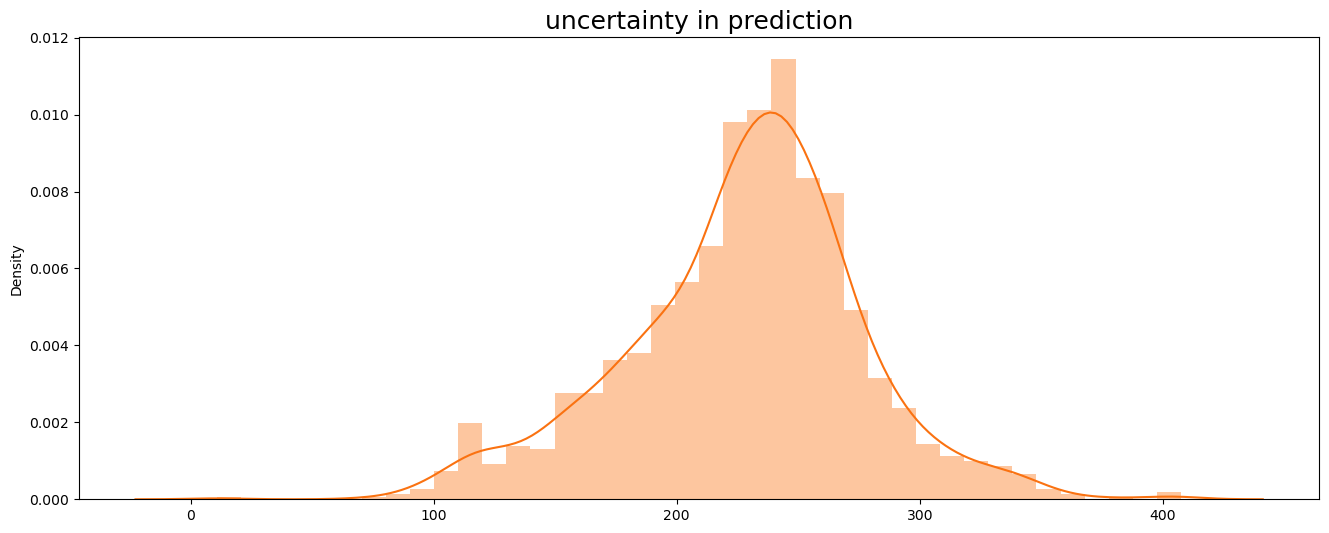

In [160]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.distplot(sigma_unc, ax=ax, color=palette_ro[1])
ax.set_title("uncertainty in prediction", fontsize=18);

**ENSEMBLING THE MODELS**

In [161]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Never smoked,Currently smokes,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y
0,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0,0,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-12,NaN,NaN
1,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0,0,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-11,NaN,NaN
2,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0,0,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-10,NaN,NaN
3,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0,0,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-9,NaN,NaN
4,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0,0,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-8,NaN,NaN


In [162]:
sub['FVC1'] = y_preds[:, 1]
sub['Confidence1'] = y_preds[:, 2] - y_preds[:, 0]

sub.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Percent_n,Age_n,base_FVC_n,base_week_n,Confidence_x,Patient_Week_x,Confidence_y,Patient_Week_y,FVC1,Confidence1
0,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-12,NaN,NaN,2811.145813,249.440002
1,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-11,NaN,NaN,2811.145813,249.440002
2,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-10,NaN,NaN,2811.145813,249.440002
3,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-9,NaN,NaN,2811.145813,249.440002
4,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-8,NaN,NaN,2811.145813,249.440002
5,ID00419637202311204720264,-7,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-7,NaN,NaN,2811.145813,249.440002
6,ID00419637202311204720264,-6,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-6,NaN,NaN,2811.145813,249.440002
7,ID00419637202311204720264,-5,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-5,NaN,NaN,2811.145813,249.440002
8,ID00419637202311204720264,-4,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-4,NaN,NaN,2811.145813,249.440002
9,ID00419637202311204720264,-3,3020,70.186855,73,Male,Ex-smoker,test,NaN,NaN,...,0.332421,0.615385,0.3724,0.179012,100.0,ID00419637202311204720264_-3,NaN,NaN,2811.145813,249.440002


In [163]:
subm = sub[['Patient_Week', 'FVC', 'Confidence', 'FVC1', 'Confidence1']].copy()
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

In [164]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

subm.head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
0,NaN,2811.145813,249.440002,2811.145813,249.440002
1,NaN,2811.145813,249.440002,2811.145813,249.440002
2,NaN,2811.145813,249.440002,2811.145813,249.440002
3,NaN,2811.145813,249.440002,2811.145813,249.440002
4,NaN,2811.145813,249.440002,2811.145813,249.440002
5,NaN,2811.145813,249.440002,2811.145813,249.440002
6,NaN,2811.145813,249.440002,2811.145813,249.440002
7,NaN,2811.145813,249.440002,2811.145813,249.440002
8,NaN,2811.145813,249.440002,2811.145813,249.440002
9,NaN,2811.145813,249.440002,2811.145813,249.440002


In [165]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2744.165289,311.507618,2180.016083,2788.426758,2801.432495,2811.145813,3139.805298
Confidence,730.0,226.063702,18.595913,198.848419,215.217957,223.059631,243.752502,249.440002
FVC1,730.0,2744.165289,311.507618,2180.016083,2788.426758,2801.432495,2811.145813,3139.805298
Confidence1,730.0,226.063702,18.595913,198.848419,215.217957,223.059631,243.752502,249.440002


In [166]:
org_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(org_test)):
    subm.loc[subm['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'FVC'] = org_test.FVC[i]
    subm.loc[subm['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'Confidence'] = 70

subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [174]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

df = df1[['Patient_Week']].copy()
df['FVC'] = 0.2*df1['FVC'] + 0.8*df2['FVC']    
df['Confidence'] = 0.04*df1['Confidence'] + 0.96*df2['Confidence']    
df.head(100)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2853.470165,242.380579
1,ID00419637202311204720264_-10,2854.181826,242.522912
2,ID00419637202311204720264_-11,2854.260899,242.538726
3,ID00419637202311204720264_-12,2854.339973,242.554541
4,ID00419637202311204720264_-2,2853.549238,242.396394
...,...,...,...
95,ID00419637202311204720264_53,2849.200198,243.013167
96,ID00419637202311204720264_54,2849.121124,243.028982
97,ID00419637202311204720264_55,2849.042051,243.044797
98,ID00419637202311204720264_56,2848.962977,243.060611


In [168]:
df.to_csv('submission.csv', index=False)